# Scoreboard Dashboard

The live scoreboard has changed the way fans follow basketball. Now, instead of needing to watch a game, fans have the option of following games through live scoreboards on several platforms. The [NBA](https://www.nba.com/games/20190104/UTACLE#/pbp) and [WNBA](https://www.wnba.com/game/20180711/NYLCON/#/play-by-play) sites have their own, along with many third party sites.

Through the [stats.nba.com](https://stats.nba.com) API, the information that powers these scoreboards is available. This notebook contains an introduction to the `scoreboardv2` endpoint of the API through the `ScoreBoard` class in the `py_ball` package. The goal is to leverage the power of Jupyter notebooks to build a prototype live scoreboard.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from py_ball import scoreboard, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

The `ScoreBoard` class requires three parameters:
- league_id: One of '00' (NBA) or '10' (WNBA)
- game_date: String of date in 'MM/DD/YYYY' corresponding to the day for which data is desired
- day_offset: String of an integer representing days from or before the date given in game_date for which data is desired. Positive values indicate days into the future, zero represents the current day, and negative values indicate days into the past

In [2]:
league_id = '00' #NBA
game_date = '01/04/2019'
day_offset = '0'

scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_offset)

scores.data.keys()

dict_keys(['GameHeader', 'LineScore', 'SeriesStandings', 'LastMeeting', 'EastConfStandingsByDay', 'WestConfStandingsByDay', 'Available', 'TeamLeaders', 'TicketLinks', 'WinProbability'])

The above shows the tables available from this endpoint. For the scoreboard, the `LineScore` table should contain most of the data needed.

In [3]:
scoreboard_df = pd.DataFrame(scores.data['LineScore'])
scoreboard_df.head(5)

,AST,FG3_PCT,FG_PCT,FT_PCT,GAME_DATE_EST,GAME_ID,GAME_SEQUENCE,PTS,PTS_OT1,PTS_OT10,...,PTS_QTR2,PTS_QTR3,PTS_QTR4,REB,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_ID,TEAM_NAME,TEAM_WINS_LOSSES,TOV
0,28,0.400,0.512,0.864,2019-01-04T00:00:00,0021800567,1,117,0,0,...,25,33,36,47,UTA,Utah,1610612762,Jazz,19-20,11
1,14,0.524,0.390,0.941,2019-01-04T00:00:00,0021800567,1,91,0,0,...,29,22,20,39,CLE,Cleveland,1610612739,Cavaliers,8-31,13
2,16,0.250,0.386,0.737,2019-01-04T00:00:00,0021800566,2,93,0,0,...,28,17,25,49,DAL,Dallas,1610612742,Mavericks,18-20,14
3,35,0.467,0.438,0.818,2019-01-04T00:00:00,0021800566,2,114,0,0,...,24,26,30,53,BOS,Boston,1610612738,Celtics,23-15,12
4,24,0.278,0.429,0.789,2019-01-04T00:00:00,0021800568,3,109,0,0,...,34,28,23,41,WAS,Washington,1610612764,Wizards,15-24,10


In [4]:
list(scoreboard_df)

['AST',
 'FG3_PCT',
 'FG_PCT',
 'FT_PCT',
 'GAME_DATE_EST',
 'GAME_ID',
 'GAME_SEQUENCE',
 'PTS',
 'PTS_OT1',
 'PTS_OT10',
 'PTS_OT2',
 'PTS_OT3',
 'PTS_OT4',
 'PTS_OT5',
 'PTS_OT6',
 'PTS_OT7',
 'PTS_OT8',
 'PTS_OT9',
 'PTS_QTR1',
 'PTS_QTR2',
 'PTS_QTR3',
 'PTS_QTR4',
 'REB',
 'TEAM_ABBREVIATION',
 'TEAM_CITY_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'TEAM_WINS_LOSSES',
 'TOV']

The `scoreboard_df` contains some game metadata and team performance, including points by period (the table schema has fields to handle games with up to 10 overtime periods!). Additionally, each row in `scoreboard_df` corresponds to a team, not a game. However, the current time and period are not available in this DataFrame. The cell below checks the `GameHeader` table for this information.

In [5]:
game_header_df = pd.DataFrame(scores.data['GameHeader'])
game_header_df.head(5)

,ARENA_NAME,AWAY_TV_BROADCASTER_ABBREVIATION,GAMECODE,GAME_DATE_EST,GAME_ID,GAME_SEQUENCE,GAME_STATUS_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,HOME_TV_BROADCASTER_ABBREVIATION,LIVE_PC_TIME,LIVE_PERIOD,LIVE_PERIOD_TIME_BCAST,NATL_TV_BROADCASTER_ABBREVIATION,SEASON,VISITOR_TEAM_ID,WH_STATUS
0,Quicken Loans Arena,ATTSN-RM,20190104/UTACLE,2019-01-04T00:00:00,0021800567,1,3,Final,1610612739,FSO,,4,Q4 -,None,2018,1610612762,1
1,TD Garden,FSSW-DAL,20190104/DALBOS,2019-01-04T00:00:00,0021800566,2,3,Final,1610612738,NBCSB,,4,Q4 - ESPN,ESPN,2018,1610612742,1
2,AmericanAirlines Arena,NBCSWA,20190104/WASMIA,2019-01-04T00:00:00,0021800568,3,3,Final,1610612748,FSSUN,,4,Q4 -,None,2018,1610612764,1
3,United Center,FSIND,20190104/INDCHI,2019-01-04T00:00:00,0021800569,4,3,Final,1610612741,WGN,,5,Q5 -,None,2018,1610612754,1
4,FedExForum,YES,20190104/BKNMEM,2019-01-04T00:00:00,0021800570,5,3,Final,1610612763,FSSE-MEM,,4,Q4 -,None,2018,1610612751,1


The `game_header_df` has the period and game time information available (columns: `LIVE_PC_TIME`, `LIVE_PERIOD`, `LIVE_PERIOD_TIME_BCAST`). With all of the above information at disposal, the list below gives some ideas for features to include on the scoreboard:
- Live period, time, and points
- Live team totals for other statistics
- Boxscore for team points by period

While the scoreboard can include much more information, starting with this list should provide a good foundation.

In [6]:
def pull_game_data(game_id):
    """ build_scoreboard gathers the data needed to create
    a scoreboard for the game identified by game_id

    @param game_id (str): Unique game identifier

    Returns:

        team_df (DataFrame): DataFrame containing
            team performance data
        game_df (DataFrame): DataFrame containing
            game metadata and live period/time
        away_team_logo (PngImageFile): PNG object of away team
            logo
        home_team_logo (PngImageFile): PNG object of home team
            logo
    """

    scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_offset)

    scores_df = pd.DataFrame(scores.data['LineScore'])
    header_df = pd.DataFrame(scores.data['GameHeader'])

    if game_id not in list(scores_df['GAME_ID']):
        print('Game ' + game_id + ' not available for date and league provided')

    team_df = scores_df[scores_df['GAME_ID']==game_id]
    game_df = header_df[header_df['GAME_ID']==game_id]

    away_team = game_df['VISITOR_TEAM_ID'].iloc[0]
    home_team = game_df['HOME_TEAM_ID'].iloc[0]

    if league_id == '00':
        league = 'NBA'
    else:
        league = 'WNBA'

    away_team_logo = image.Logo(league=league,
                                team_id=str(away_team))
    home_team_logo = image.Logo(league=league,
                                team_id=str(home_team))

    return team_df, game_df, away_team_logo.image, home_team_logo.image

In [7]:
team_df, game_df, away_team_logo, home_team_logo = pull_game_data('0021800566')

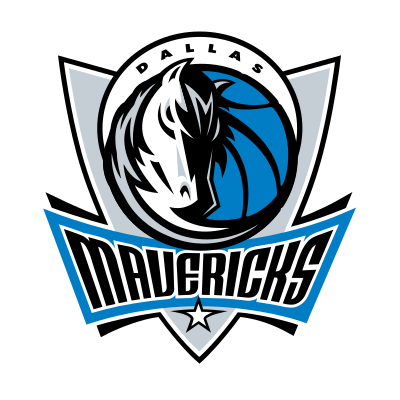

In [8]:
away_team_logo